In [1]:
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.visualization.scatter import Scatter
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import random
import time

## **0: Problem (sacred cell)**

In [53]:
class TSPProblem(Problem):
    def __init__(self, n_cities: int, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))

        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each individual in "x" (population)
        distances = []
        times = []
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

# ---------------------------------------
problem = TSPProblem(n_cities=100)
algorithm = NSGA2(pop_size=100)
res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               verbose=False)
res2 = minimize(problem,
                algorithm,
                ('n_gen', 1000),
                verbose=False)

np.random.seed(None) # Reset random seed for custom solution

## **0. Visualization functions**

### **0.1 Simple plot**

In [56]:
def plot_comparison(solution: np.ndarray, save_path: str) -> None:
    """Compare Pareto Fronts in a plot"""
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(res.F[:, 0], res.F[:, 1], color='red', facecolor='none', marker='o', label="NSGA-II 100 gen")
    ax.scatter(res2.F[:, 0], res2.F[:, 1], color='blue', marker='x', label="NSGA-II 1000 gen")
    ax.scatter(solution[:, 0], solution[:, 1], c='green', marker="*", label="Custom solution")
    ax.set_xlabel('Total Distance')
    ax.set_ylabel('Total Time')
    ax.legend(loc='upper left')
    plt.savefig(save_path)
    plt.show()

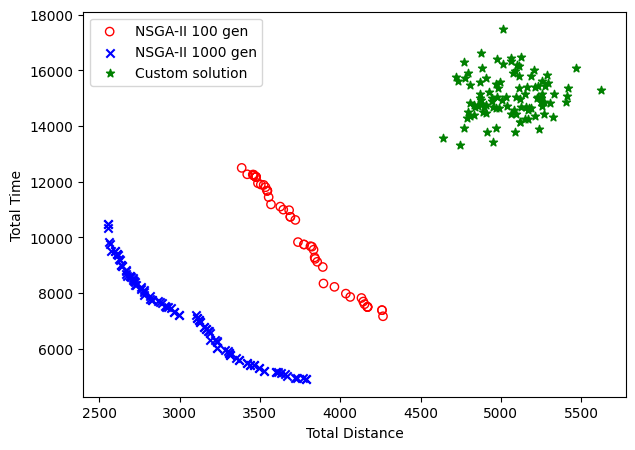

In [57]:
number_of_cities = 100
number_of_individuals = 100

population = np.array([np.random.permutation(number_of_cities) for _ in range(number_of_individuals)])
fitnesses = problem.evaluate(population)
plot_comparison(fitnesses)

### **0.2 GIF creation**

In [58]:
def plot_pareto_front_animation(generations_data: list[np.ndarray], save_path: str, interval=500):
    """Save GIF from the historical Pareto Front"""
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")

    def update(frame):
        ax.clear()
        ax.set_title(f"Generation {frame + 1}")
        solution = generations_data[frame]

        ax.scatter(res.F[:, 0], res.F[:, 1], color='red', facecolor='none', marker='o', label="NSGA-II 100 gen")
        ax.scatter(res2.F[:, 0], res2.F[:, 1], color='blue', marker='x', label="NSGA-II 1000 gen")
        ax.scatter(solution[:, 0], solution[:, 1], c='green', marker="*", label="Custom solution")
        ax.legend(loc='upper right')

    ani = FuncAnimation(fig, update, frames=len(generations_data), interval=interval)
    ani.save(save_path, writer='pillow')
    print(f"Animation saved to {save_path}")

Animation saved to MOO-TSP-evolution.gif


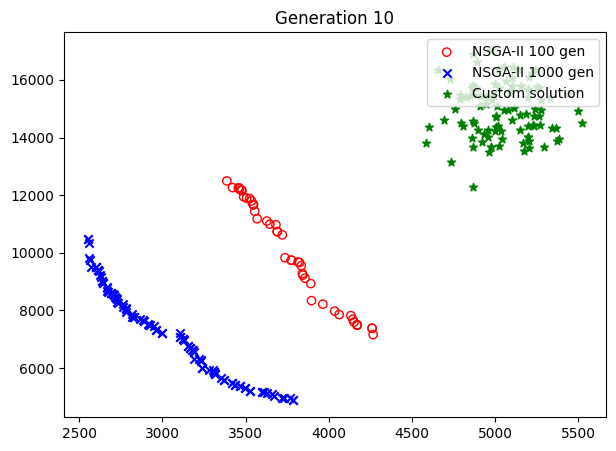

In [59]:
number_of_cities = 100
number_of_individuals = 100

generations_data = []
for i in range(10):
    population = np.array([np.random.permutation(number_of_cities) for _ in range(number_of_individuals)])
    fitnesses = problem.evaluate(population)
    generations_data.append(fitnesses)

plot_pareto_front_animation(generations_data, save_path="MOO-TSP-prueba.gif")

## **1. Algorithm functions**

### **1.1 Crossovers**

In [44]:
def sbx_crossover(parent1, parent2, problem):
    """
    Apply crossover to a single pair of parents.

    Parameters:
        parent1 (np.ndarray): The first parent.
        parent2 (np.ndarray): The second parent.

    Returns:
        np.ndarray: The offspring pair after crossover.
    """
    eta = 15
    lower_bounds, upper_bounds = problem.bounds()

    u = np.random.rand(len(parent1))
    beta = np.where(u <= 0.5, (2 * u) ** (1 / (eta + 1)), (1 / (2 * (1 - u))) ** (1 / (eta + 1)))
    child1 = 0.5 * ((1 + beta) * parent1 + (1 - beta) * parent2)
    child2 = 0.5 * ((1 - beta) * parent1 + (1 + beta) * parent2)

    child1 = np.clip(child1, lower_bounds, upper_bounds)
    child2 = np.clip(child2, lower_bounds, upper_bounds)

    return child1, child2

### **1.2 Mutations**

In [66]:
def pm_mutate(individual, problem):
    """
    Perform polynomial mutation on an individual.

    Parameters:
        individual (np.ndarray): The individual to mutate.
        problem (Problem): The problem instance to get the bounds.

    Returns:
        np.ndarray: The mutated individual.
    """
    
    lower_bounds, upper_bounds = problem.bounds()
    mutated_individual = individual.copy()  # Make a copy to avoid modifying the original

    for j in range(len(individual)):  # Iterate over each gene in the individual
        # Polynomial mutation
        if np.random.rand() < 0.1:  # Mutation probability
            delta = np.random.uniform(-1, 1)  # This is an example mutation delta
            mutated_individual[j] += delta  # Apply mutation
            mutated_individual[j] = np.clip(mutated_individual[j], lower_bounds[j], upper_bounds[j])  # Clip to bounds

    return mutated_individual

# ---------------------------------------
def multi_mutate(individual: np.ndarray) -> np.ndarray:
        """Mutate an individual. Return mutated individual"""
        pmut = 0.1
        
        def mutate_random_variable(individual: np.ndarray) -> np.ndarray:
            for i in range(len(individual)):
                if random.random() <= pmut:
                    individual[i] = np.random.uniform(-1, 1)
            return individual
        
        def mutate_offset_variable(individual: np.ndarray) -> np.ndarray: 
            for i in range(len(individual)):
                if random.random() <= pmut:
                    if individual[i] + np.random.uniform(-0.1, 0.1) >= 0.0 and individual[i] + np.random.uniform(-0.1, 0.1) <= 1.0:
                        individual[i] += np.random.uniform(-0.1, 0.1)
            return individual
        
        def mutate_set_random(individual: np.ndarray) -> np.ndarray:
            """reset the hole individual"""
            individual = np.random.rand(len(individual))
            return individual
        
        if random.random() < pmut:
            mutations = [mutate_random_variable, mutate_offset_variable, mutate_set_random]
            operator = random.choice(mutations)
            return operator(individual)
        else:
            return individual

### **1.3 Selections**

In [80]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def tournament_by_rank_and_crowding(population, fitness, ranks, crowding_distances):
    # Randomly select two individuals for the tournament
    indices = np.random.choice(len(population), size=2, replace=False)
    individual1, individual2 = population[indices]
    fitness1, fitness2 = fitness[indices]

    # Extract additional properties for comparison
    rank1, cd1 = ranks[indices[0]], crowding_distances[indices[0]]
    rank2, cd2 = ranks[indices[1]], crowding_distances[indices[1]]

    if rank1 < rank2:
        return individual1
    elif rank2 < rank1:
        return individual2

    # If rank or domination didn't make a decision, compare by crowding distance
    return (
        individual1 if cd1 > cd2 else individual2 if cd2 > cd1 else (
            individual1 if np.random.rand() < 0.5 else individual2
        )
    )

# ---------------------------------------
def calcular_crowding_distance(valores_objetivo):
    n_ind, n_obj = valores_objetivo.shape
    crowding = np.zeros(n_ind)

    # Para cada objetivo, calcular la distancia crowding
    for m in range(n_obj):
        # Ordenar por el m-ésimo objetivo
        sorted_indices = np.argsort(valores_objetivo[:, m])
        sorted_obj = valores_objetivo[sorted_indices, m]

        # Asignar infinito a los extremos (frontera del rango)
        crowding[sorted_indices[0]] = np.inf
        crowding[sorted_indices[-1]] = np.inf

        # Calcular la distancia normalizada para los intermedios
        norm = sorted_obj[-1] - sorted_obj[0]
        if norm > 0:
            for i in range(1, n_ind - 1):
                crowding[sorted_indices[i]] += (
                    (sorted_obj[i + 1] - sorted_obj[i - 1]) / norm
                )

    return crowding

def seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=10):
    """
    Realiza la selección por torneo para problemas multiobjetivo utilizando Pymoo.

    Parameters:
    
    poblacion: Lista de individuos.
    valores_objetivo: Matriz de valores objetivo (N x M).
    n_individuals: Número de individuos a seleccionar.
    T: Tamaño del torneo (default: 6).

    Returns:
    padres: Lista de individuos seleccionados.
    """
    padres = []

        # Realizar torneo para seleccionar cada padre
    for _ in range(n_individuals):
        # Seleccionar T competidores al azar
        indices = np.random.choice(len(poblacion), size=T, replace=False)
        competidores = [poblacion[i] for i in indices]
        objetivos_competidores = valores_objetivo[indices]

        # Identificar los no dominados usando Pymoo
        nds = NonDominatedSorting()
        frentes = nds.do(objetivos_competidores, only_non_dominated_front=True)
        no_dominados = np.atleast_1d(frentes[0])  # Convertir siempre a array de al menos 1D

        if len(no_dominados) == 1:
            # Si hay un único no dominado, seleccionarlo
            ganador = competidores[no_dominados[0]]
        else:
            # Si hay empate, calcular distancia crowding
            crowding = calcular_crowding_distance(objetivos_competidores)
            idx_mejor = no_dominados[np.argmax(crowding[no_dominados])]
            ganador = competidores[idx_mejor]

        padres.append(ganador)

    return padres

### **1.4 Algorithm**

In [100]:
class SoftMajo:
    def __init__(self, problem: Problem, 
                 p_cross = 1, p_mut = 0.1, population_size=100, generations=100, 
                 crossover_method="sbx", mutation_method="pm", 
                 elitism = False, selection_method="tournament_by_rank_and_crowding", selection_approach="full_population"):
        
        self.problem = problem
        self.population_size = population_size
        self.generations = generations
        self.selection_approach = selection_approach
        self.elitism = elitism

        self.generations_history = list()
        self.pareto_history = list()

        self.p_cross = p_cross
        self.p_mut = p_mut

        self.crossover_method = crossover_method
        self.mutation_method = mutation_method
        self.selection_method = selection_method

    def initialize_population(self):
        lower_bounds, upper_bounds = self.problem.bounds()
        return np.random.uniform(lower_bounds, upper_bounds, (self.population_size, self.problem.n_var))

    def evaluate_population(self, population):
        return self.problem.evaluate(population, return_values_of=['F'])
        
    def crossover(self, parent1, parent2):
        if(self.crossover_method == "sbx"):
            return sbx_crossover(parent1, parent2, self.problem)
        else:
            raise ValueError("Invalid crossover method")

    def evolve(self, trace: int = 100):
        # Initialize population
        population = self.initialize_population()

        for generation in range(self.generations):
            # Evaluate the population
            fitness = self.evaluate_population(population)

            self.generations_history.append(fitness)
            pareto_front, pareto_fitness = self.calculate_pareto_front(population, fitness)
            self.pareto_history.append(pareto_fitness)
            
            # Compute rank and crowding distance
            self._ranks = self.assign_rank(population, fitness)
            self._crowding_distances = self.assign_crowding_distance(population, fitness)

            new_population = list()

            if(self.elitism):
                # Add the pareto front to the new population
                new_population.extend(pareto_front)

            while(self.population_size > len(new_population)):
                # Perform selection
                parent1 = self.selection(population, fitness)
                parent2 = self.selection(population, fitness)

                offspring1, offspring2 = parent1, parent2

                if(random.random() < self.p_cross):
                    # Apply crossover
                    offspring1, offspring1 = self.crossover(parent1, parent2)

                if(random.random() < self.p_cross):
                    # Apply mutation to offspring1
                    offspring1 = self.mutate(offspring1)

                if(random.random() < self.p_cross):
                    # Apply mutation to offspring2
                    offspring2 = self.mutate(offspring2)

                # Add the individuals to the new population
                new_population.append(offspring1)
                new_population.append(offspring2)

            # plot the trace
            if generation % trace == 0:
                print(f"Generation {generation}")

            population = np.array(new_population)
            
        # Final evaluation
        final_fitness = self.evaluate_population(population)
        return population, final_fitness
    
    def selection(self, population, fitness):
        """
        Perform the selected selection method using the selected approach.

        Returns:
            np.ndarray: The selected individual.
        """
        if self.selection_approach == "pareto_front":
            selection_population, selection_fitness = self.calculate_pareto_front(population, fitness)
        else:
            selection_population, selection_fitness = population, fitness

        if self.selection_method == "torneo_Javi":
            padres = np.array(seleccionar_poblacion(population, fitness, 100, T=10))
            indice = np.random.randint(0, len(padres))
            return padres[indice]
        
        if self.selection_method == "tournament_by_rank_and_crowding":
            return tournament_by_rank_and_crowding(selection_population, selection_fitness, self._ranks, self._crowding_distances)
        else:
            raise ValueError("Invalid selection method")

    def assign_rank(self, population, fitness):
        """
        Assign non-dominated ranks to the population.
        
        Parameters:
            population (list): The population of individuals.
            fitness (np.ndarray): The fitness values of the population.

        Returns:
            np.ndarray: Array of ranks for the population.
        """
        n = len(population)
        ranks = np.zeros(n, dtype=int)
        domination_count = np.zeros(n, dtype=int)
        dominated_solutions = [[] for _ in range(n)]
        fronts = [[]]

        # Calculate domination relationships
        for i in range(n):
            for j in range(n):
                if np.all(fitness[i] <= fitness[j]) and np.any(fitness[i] < fitness[j]):
                    dominated_solutions[i].append(j)
                elif np.all(fitness[j] <= fitness[i]) and np.any(fitness[j] < fitness[i]):
                    domination_count[i] += 1
            
            if domination_count[i] == 0:  # No one dominates this solution
                ranks[i] = 0
                fronts[0].append(i)
        
        # Generate the fronts
        current_front = 0
        while fronts[current_front]:
            next_front = []
            for i in fronts[current_front]:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        ranks[j] = current_front + 1
                        next_front.append(j)
            current_front += 1
            fronts.append(next_front)
        
        return ranks
    
    def assign_crowding_distance(self, population, fitness):
        """
        Assign crowding distance to the population.
        
        Parameters:
            population (list): The population of individuals.
            fitness (np.ndarray): The fitness values of the population.

        Returns:
            np.ndarray: Array of crowding distances for the population.
        """
        n, num_objectives = fitness.shape
        distances = np.zeros(n)
        
        for m in range(num_objectives):
            sorted_indices = np.argsort(fitness[:, m])
            min_value = fitness[sorted_indices[0], m]
            max_value = fitness[sorted_indices[-1], m]
            distances[sorted_indices[0]] = distances[sorted_indices[-1]] = np.inf
            
            if max_value > min_value:  # Avoid division by zero
                for i in range(1, n - 1):
                    distances[sorted_indices[i]] += (
                        (fitness[sorted_indices[i + 1], m] - fitness[sorted_indices[i - 1], m]) /
                        (max_value - min_value)
                    )
        
        return distances

    def mutate(self, population):
        if(self.mutation_method == "pm"):
            return pm_mutate(population, self.problem)
        elif(self.mutation_method == "multi_mutate"):
            return multi_mutate(population)
        else:
            raise ValueError("Invalid mutation method")
        
    def calculate_pareto_front(self, population, fitness):
        """
        Calculate the Pareto front for the given population.

        Parameters:
            population (np.ndarray): The population.
            fitness (np.ndarray): The objective values of the population.

        Returns:
            np.ndarray: The Pareto-optimal solutions.
            np.ndarray: The corresponding objective values of the Pareto front.
        """
        is_pareto = np.ones(fitness.shape[0], dtype=bool)
        for i, f1 in enumerate(fitness):
            if is_pareto[i]:
                is_pareto[is_pareto] = np.any(fitness[is_pareto] < f1, axis=1)
                is_pareto[i] = True
        return population[is_pareto], fitness[is_pareto]
    

## **2. Problem Resolution**

Generation 0
Generation 100
Generation 200
Generation 300
Generation 400
Generation 500
Generation 600
Generation 700
Generation 800
Generation 900
*******Tiempo evolución: 4 minutos y 50.96 segundos*******


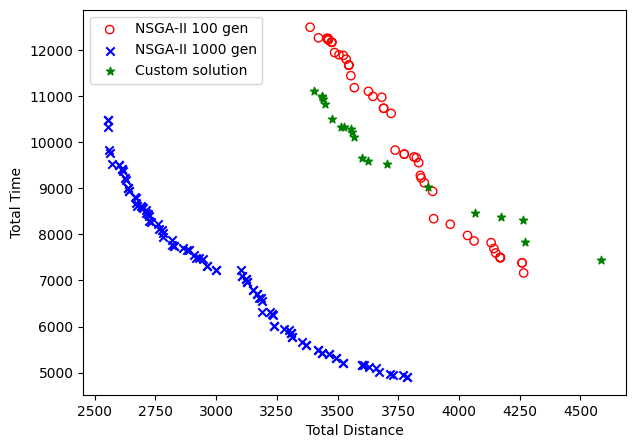

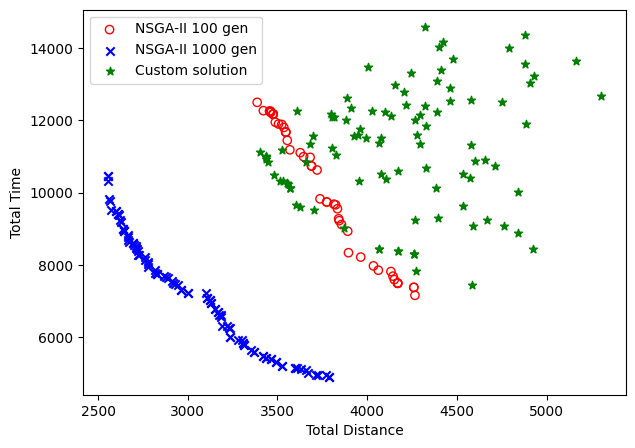

In [102]:
start = time.time()

ea_zdt1 = SoftMajo(problem, p_cross=0.8, p_mut=0.3, population_size=100, generations=1000, 
              crossover_method="sbx", mutation_method="pm", selection_method="torneo_Javi",
              elitism=True, selection_approach="pareto_front")
final_population, final_fitness = ea_zdt1.evolve(trace=100)

minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

pareto_population, pareto_fitness = ea_zdt1.calculate_pareto_front(final_population, final_fitness)
plot_comparison(pareto_fitness)
plot_comparison(final_fitness)

Animation saved to MOO-TSP-evolution.gif


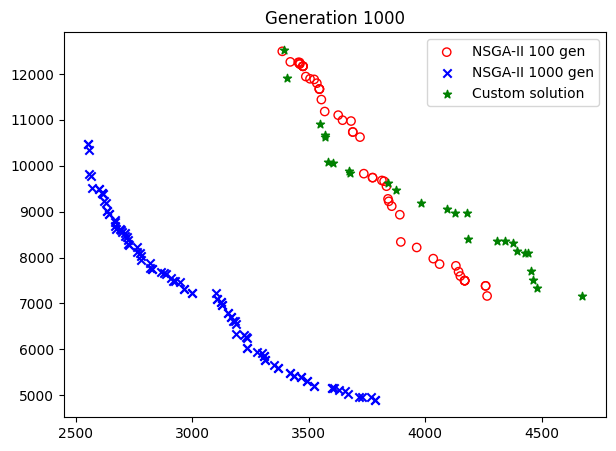

In [76]:
plot_pareto_front_animation(ea_zdt1.pareto_history, save_path="MOO-TSP-evolution.gif", interval=100)

## **3. Métricas**

In [134]:
from pymoo.indicators.hv import Hypervolume

def metrics_function(pareto_front: np.ndarray[np.ndarray]) -> tuple[float, float, float]:
    """Calculate the hypervolume and epsilon indicators for the final Pareto front."""

    # Calculate the hypervolume indicator
    ref_point=np.array([5000, 14000])
    hv = Hypervolume(ref_point)
    hypervolume = hv.do(pareto_front)

    # SPA metric
    distances = np.linalg.norm(pareto_front[:, None] - pareto_front[None, :], axis=-1)
    SPA = np.mean(np.min(distances + np.diag(np.inf * np.ones(len(distances))), axis=1))

    # dispersion metric
    minimum = np.min(pareto_front, axis=0)
    maximum = np.max(pareto_front, axis=0)
    SPR = np.linalg.norm(maximum - minimum)

    return hypervolume, SPA, SPR 

In [136]:
hv, spa, spr = metrics_function(pareto_fitness)
print(f"Hypervolume Custom: {hv}")
print(f"SPR Custom: {spr}")
print(f"SPA Custom: {spa}")

hv1, spa1, spr1 = metrics_function(res.F)
print(f"Hypervolume NSGA-II 100 gen: {hv1}")
print(f"SPR NSGA-II 100 gen: {spr1}")
print(f"SPA NSGA-II 100 gen: {spa1}")

hv2, spa2, spr2 = metrics_function(res2.F)
print(f"Hypervolume NSGA-II 1000 gen: {hv2}")
print(f"SPR NSGA-II 1000 gen: {spr2}")
print(f"SPA NSGA-II 1000 gen: {spa2}")

Hypervolume Custom: 8653562.441112392
SPR Custom: 3860.8404676648975
SPA Custom: 140.11576462444188
Hypervolume NSGA-II 100 gen: 8835006.65159851
SPR NSGA-II 100 gen: 5403.70086285439
SPA NSGA-II 100 gen: 55.05817919425571
Hypervolume NSGA-II 1000 gen: 20007673.39207145
SPR NSGA-II 1000 gen: 5704.402940634535
SPA NSGA-II 1000 gen: 19.817610535889333
